Livetime: 92.962


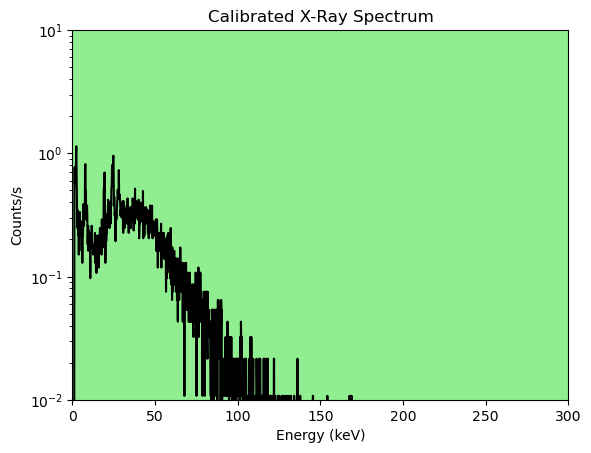

Accounting for Efficiencies...


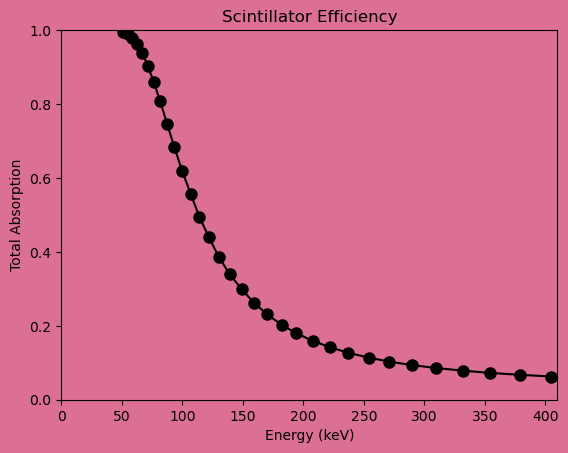

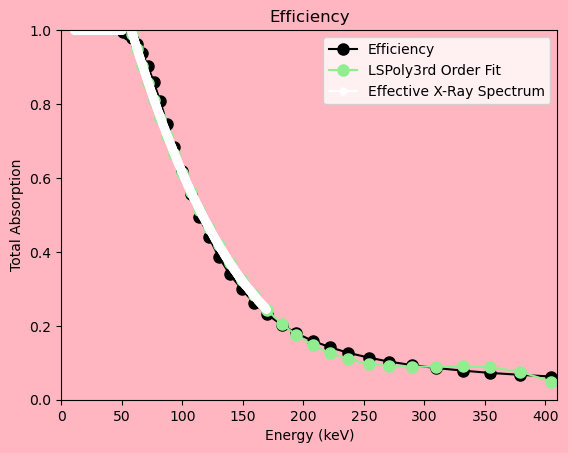

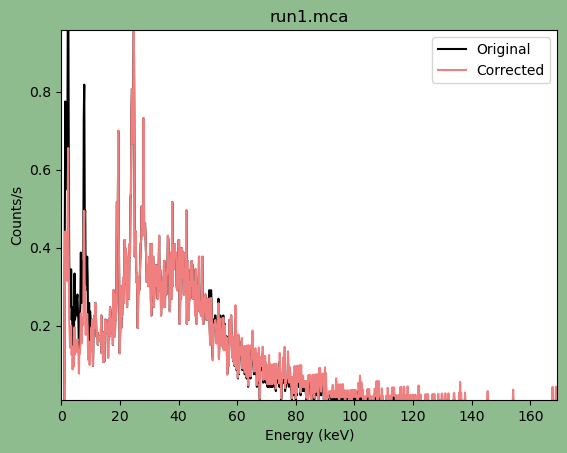

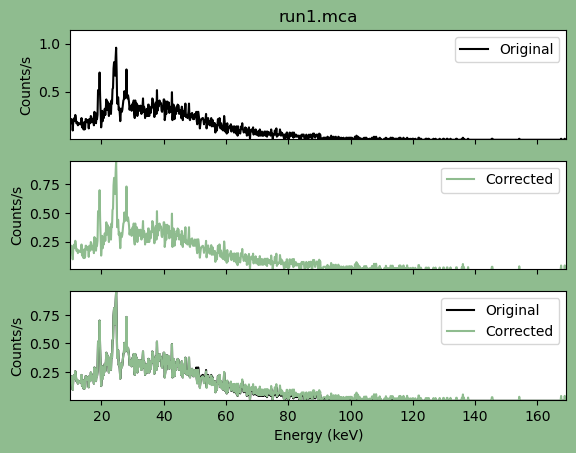


Calculating Spectral Temperature...
a = -1.1342558905774498 b = -0.005829947168407195 Ts = 171.52814101284744 error = 0.06255876929232507
Sum of Counts in Range 86.29282542785381 +/- 0.9634620552921856


()

In [7]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt
from pylab import figure, show
#04/27/15 Corrected efficiency below 60 keV. Below 10 keV correction is not correct. Ignore data below 10 keV.
#9/18/25 testing commit
#testing part 2


def checklivetime():
    xbgname = input("X-ray Plus Background file name: ")    # request file names
    names = [xbgname]
    lists = [[]] * len(names)
    livetime = lists
    for i in range(len(lists)): # check for normalization
        r = open(names[i], 'r')
            #print names[i]
        numlines = 0
        while r.readline(): numlines += 1
        r.seek(0)
        for j in range(numlines):
            lineA = r.readline().split()
            if (lineA[0] == 'LIVE_TIME'):
                livetime[i] = float(lineA[2])
                break
        r.close()
        #print(livetime)

    multip1 = float(livetime[0])
    (xbgname) = GetxbgFile(xbgname, multip1)                    # calls GetxbgFile function to open data
    return(xbgname)

#-----------------------------------------------------------------------------------

EffEnergy = []
EffAbs = []
def eff(E):
    # SCINTILLATOR EFFICIENCY: probability that a photon will be completely absorbed.
    # total attenuation 1000micron with 4mil Be window CdTe from Amptek website

    EffEnergy = [51.2, 54.7, 58.5, 62.5, 66.8, 71.5, 76.4, 81.7, 87.3, 93.3, 99.8, 107, 114, 122, 130, 139, 149, 159, 170, 182, 194, 208, 222, 237, 254, 271, 290, 310, 332, 354, 379, 405]
    EffAbs = [0.994, 0.989, 0.98, 0.963, 0.938, 0.903, 0.859, 0.807, 0.747, 0.684, 0.619, 0.556, 0.495, 0.439, 0.387, 0.34, 0.299, 0.263, 0.231, 0.203, 0.18, 0.159, 0.142, 0.127, 0.114, 0.103, 0.0937, 0.0856, 0.0787, 0.0726, 0.0674, 0.0628]

    fig = figure(facecolor = 'palevioletred')                   # plot efficiency
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'palevioletred')
    ax.plot(EffEnergy, EffAbs, linestyle = '-', color = 'black', marker = 'o', markersize = 8)
    ax.set_xlim(0, 410)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Energy (keV)', color = 'black')
    ax.set_ylabel('Total Absorption', color = 'black')          # is this an accurate description?
    ax.set_title('Scintillator Efficiency')
    #show()
    return(EffEnergy, EffAbs)

#-----------------------------------------------------------------------------------

# Function to open X-Ray & Background Data
def GetxbgFile(xbgname, multip1):
    (xbgD, xbgnDlines) = ReadData(xbgname)               # calls ReadData function
    print('Livetime:', multip1)
    for i in range(xbgnDlines):                                 # divide data by livetime, now in counts/s
        xbgD[i] = xbgD[i] / multip1
        if xbgD[i] <= 0:
            xbgD[i] = 0.0001

    aCal = 0.16594626                                      # CHECK GAIN
    bCal = -0.4991754892        
    #print('Energy Calibration = ' +  str(aCal) + '*Channel + ' + str(bCal))
    E = []                                                      # calibrated energy spectrum
    for i in range(xbgnDlines):
        energy = aCal*i + bCal
        E.append(energy)
    #print(E)
    fig = figure(facecolor = 'w')                               # plot calibrated x-ray spectrum 
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'lightgreen')
    #ax.step(E, xbgD, where = 'pre', color = 'k')
    ax.semilogy(E, xbgD, linestyle = '-', color = 'black')
    ax.set_xlim(0, 300)
    ax.set_ylim(0.01, 10)
    ax.set_xlabel('Energy (keV)', color = 'black')
    ax.set_ylabel('Counts/s', color = 'black')
    ax.set_title('Calibrated X-Ray Spectrum')
    show()
    
    print('Accounting for Efficiencies...')                          # correct for detector efficiencies           # if NO, will throw error on Spectral Temp calc                       
    (EffEnergy, EffAbs) = eff(E)                            # call Absolute Efficiency function for CdTe detector
    parameters, covariance = curve_fit(LSpoly3, EffEnergy, EffAbs) # call Least-Squares 3rd-Order Polynomial Fit for Scintillator Efficiency function
    fit_a = parameters[0]
    fit_b = parameters[1]
    fit_c = parameters[2]
    fit_d = parameters[3]
    #print('a, b, c, d = ', fit_a, fit_b, fit_c, fit_d)

    fit = []                                                # y = a + bx + cx^2 + dx^3
    Effxray = []                                            # this fits a 3rd-order polynomial to the efficiency curve (could try higher-order fit)
    diff = []
    for i in range(len(EffEnergy)):
        fits = fit_a + fit_b*EffEnergy[i] + fit_c*EffEnergy[i]*EffEnergy[i] + fit_d*EffEnergy[i]*EffEnergy[i]*EffEnergy[i]
        fit.append(fits)
    for i in range(len(E)):
        if E[i] < 50 and E[i] > 10:
            Effxrays = 1.0
            Effxray.append(Effxrays)
        else:
            Effxrays = fit_a + fit_b*E[i] + fit_c*E[i]*E[i] + fit_d*E[i]*E[i]*E[i]
            Effxray.append(Effxrays)

    fig = figure(facecolor = 'lightpink')                   # efficiency plot
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'lightpink')
    ax.plot(EffEnergy, EffAbs, linestyle = '-', color = 'black', marker = 'o', markersize = 8, label = 'Efficiency')
    ax.plot(EffEnergy, fit, linestyle = '-', color = 'lightgreen', marker = 'o', markersize = 8, label = 'LSPoly3rd Order Fit')
    ax.plot(E, Effxray, linestyle = '-', color = 'white', marker = 'o', markersize = 5, label = 'Effective X-Ray Spectrum')     # is this right? in sensitive region (>50 keV)
    ax.set_xlim(0, 410)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Energy (keV)', color = 'black')
    ax.set_ylabel('Total Absorption', color = 'black')
    ax.set_title('Efficiency')
    ax.legend()
    #show()
        
    #Abs_Eff = spline(EffEnergy, EffAbs)                     # call Spline function
    #A_E_2 = []                                              # empty array for Absolute Efficiency Values at requested Energy Values
    #for i in range(len(E)):
        #A_E_2_temp = splint(EffEnergy, EffAbs, Abs_Eff, E[i])   # call Splint function
        #A_E_2.append(A_E_2_temp)
    #print(A_E_2)

    CorrectedxbgD = []
    nE = []                                                 # number of counts * energy
    for i in range(len(E)):
        CorrectedxbgD.append(xbgD[i]/Effxray[i])            # correction applied
        nE.append(CorrectedxbgD[i]*E[i])
    #print(E[i], CorrectedxbgD[i], nE[i])        

    fig = figure(facecolor = 'darkseagreen')                        # efficiency plot
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'white')
    ax.plot(E, xbgD, linestyle = '-', color = 'black', label = 'Original')
    ax.plot(E, CorrectedxbgD, linestyle = '-', color = 'lightcoral', label = 'Corrected')
    ax.set_xlim(0, max(E))
    ax.set_ylim(0.01, max(CorrectedxbgD))
    ax.set_xlabel('Energy (keV)', color = 'black')
    ax.set_ylabel('Counts/s', color = 'black')
    ax.set_title(xbgname)
    ax.legend()
    show()

    writename = "Corrected" + xbgname                       # create output file
    wr = open(writename, 'w')
    for i in range(len(E)):
        wr.write("%f %f %f %f\n"%(E[i], xbgD[i], CorrectedxbgD[i], nE[i])) # %f is replaced with the arguments
    wr.write("\n")

    f, (ax1, ax2, ax3) = plt.subplots(3, sharex = True, sharey = False, facecolor = 'darkseagreen') # nE vs. E
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'white')
    ax1.plot(E, xbgD, linestyle = '-', color = 'black', label = 'Original')
    ax1.set_xlim(10, max(E))
    ax1.set_ylim(0.01, max(xbgD))
    ax2.plot(E, CorrectedxbgD, linestyle = '-', color = 'darkseagreen', label = 'Corrected')
    ax2.set_xlim(10, max(E))
    ax2.set_ylim(0.01, max(CorrectedxbgD))
    ax3.plot(E, xbgD, linestyle = '-', color = 'black', label = 'Original')
    ax3.plot(E, CorrectedxbgD, linestyle = '-', color = 'darkseagreen', label = 'Corrected')
    ax3.set_xlim(10, max(E))
    ax3.set_ylim(0.01, max(CorrectedxbgD))
    ax3.set_xlabel('Energy (keV)', color = 'black')
    ax1.set_ylabel('Counts/s', color = 'black')
    ax2.set_ylabel('Counts/s', color = 'black')
    ax3.set_ylabel('Counts/s', color = 'black')
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax1.set_title(xbgname)
    show()
    print()

    print('Calculating Spectral Temperature...')
    beginE = float(input("Enter beginning Energy (keV): "))
    endE = float(input("Enter ending Energy (keV): "))
    for i in range(len(E)):
        if beginE < E[i]:
            beginlocation = i
            break
    for i in range(len(E)):
        if endE < E[i]:
            endlocation = i
            break

    TempxD = []
    TempE = []
    SumCounts = 0.
    for i in range(beginlocation, endlocation):
        #print(E[i], xbgD[i], CorrectedxbgD[i], np.log(CorrectedxbgD[i]))
        TempxD.append(np.log(CorrectedxbgD[i]))
        TempE.append(E[i])
        SumCounts = SumCounts + CorrectedxbgD[i]

    #aLS, bLS = LeastSquares(TempE, TempxD, multip1)            # use a linear fit to get the slope for the spectral temperature
    #specTog = abs(1.0 / bLS)
    #print('og: , a =',aLS, 'b =', bLS, 'Tsog =', specTog, 'chi_squaredLS')

    result = linregress(TempE, TempxD)                          # use a linear fit to get the slope for the spectral temperature
    specT = abs(1.0 / result.slope)
    print('a =', result.intercept, 'b =', result.slope, 'Ts =', specT, 'error =', result.intercept_stderr)

    stdDev = np.sqrt(SumCounts/multip1)
    #print('Ts = ', specT)
    wr.write("Ts ")
    wr.write("%f \n"%(specT))
    wr.write("\n")
    print('Sum of Counts in Range', SumCounts, '+/-', stdDev)
    wr.write("Sum in Range ")
    wr.write("%f \n"%(SumCounts))
    wr.write("\n")

    return()

#-----------------------------------------------------------------------------------

def ReadData(name):                                             # read value of livetime, total # lines, return channels, counts
    f = open(name, 'r')
    nlines = 0                                                  # nlines = total number of lines in file
    nDlines = 0                                                  
    while f.readline():
        nlines += 1
        #print(f.read())                                        # check to see it's reading exactly what's in the .mca file
    #print('total # lines in file =', nlines)

    f.seek(0)                                                   # set readline pointer back to 0

    for i in range(nlines):
        line = f.readline().split()
        #print(line)
        if line[0] == '<<DATA>>':
            Dlocation = i                                       # Dlocation = data starts after this line
            nDlines = nlines - 1 - Dlocation - 1
            break                                               # break stops readline where it found the '<<DATA>>'
    #print(nDlines, nlines, Dlocation)                          # check against .mca

    D = []

    for i in range(nDlines):
        Ds = f.readline().split()                               # starts reading lines again at the beginning of the data
        if Ds[0] == '<<END>>':
            endpoint = i                                        # end of data ('<<END>>')
            break
        D.append(int(Ds[0]))                                    # turns bin data into list
    nDlines = len(D)                                            # nDlines = number of channels with data (1024)
    f.close()
    return(D, nDlines)                                          # gives values to line 58
#-----------------------------------------------------------------------------------

#def LeastSquares(x, y, multip1):                                # LEAST-SQUARES FIRST ORDER FIT
    n = len(x)
    xsum = 0
    ysum = 0
    xsqsum = []
    ysqsum = []
    xysum = []

    for i in range(n):
        xsum = xsum + x[i]
        ysum = ysum + y[i]
        xsqsum.append(x[i]*x[i])
        ysqsum.append(y[i]*y[i])
        xysum.append(x[i]*y[i])
    xsqsum = sum(xsqsum)
    ysqsum = sum(ysqsum)
    xysum = sum(xysum)
    xsumsq = xsum * xsum
    ysumsq = ysum * ysum
    #print('xsum = ', xsum, 'ysum = ', ysum, 'x2sum = ', xsqsum, 'y2sum = ', ysqsum)
    
    a = 1.0 * (ysum * xsqsum - xsum * xysum) / (n * xsqsum - xsumsq)    # y = a + bx
    b = 1.0 * (n * xysum - xsum * ysum) / (1.0 * n * xsqsum - xsumsq)

    chisquared = 0.
    for i in range(n):
        #print(y[i], y[i]/(multip1 ** 2))
        #print(y[i], np.sqrt((int(y[i]) / multip1 ** 2)))
        diff = (((a + b * x[i]) - y[i]) ** 2) / np.sqrt (y[i] / multip1 ** 2)
        chisquared = chisquared + diff
    print('chisquared = ', chisquared)

    chi_squared = 0.
    for i in range(n):                                          # chi-squared statistic
        sigma_squared = y[i]                                    # for statistical uncertainties (counting experiments)
        chi_squared = chi_squared + (1 / sigma_squared) * (y[i] - a - b * x[i]) ** 2

    return(a,b)

#-----------------------------------------------------------------------------------

def LSpoly3(x, a, b, c, d):                                     # least-squares 3rd-order polynomial fit
    y = a + b*x + c*x*x + d*x*x*x                               # y = a + bx + cx^2 + dx^3
    return y

#-----------------------------------------------------------------------------------

def spline(x, y):                                               # by Damon Todd
    n = len(x)
    D = []
    B = []
    y2 = []
    
    for i in range(n):
        D.append(0.)
        B.append(0.)
        y2.append(0.)

    dx = x[1] - x[0]
    B[0] = y2[0] = 0.0
    D[0] = 1.0
    y2[1] = dx
    D[1] = 4.0 * (dx)
    B[1] = 6.0 * (y[2] - 2.0 * y[1] + y[0]) / dx
    for j in range(2, n - 1):
        i = j - 1
        k = j + 1
        B[j] = y2[i] / D[i]
        y2[j] = dx
        D[j] = 4.0 * dx - y2[j] * B[j]
        B[j] = 6.0 * (y[j + 1] - 2.0 * y[j] + y[j - 1]) / dx - B[j - 1] * B[j] # should the whole denom be in parentheses??

    B[n - 1] = 0.0
    y2[n - 1] = 0.0
    y2[n - 2] = B[n - 2] / D[n - 2]
    for i in range(n - 3, 0, -1):
        y2[i] = (B[i] - y2[i] * y2[i + 1]) / D[i]
    y2[0] = 0.0
    return y2

#-----------------------------------------------------------------------------------

def splint(x, y, y2, X):                                        # by Damon Todd
    n = len(y)
    h = x[2] - x[1]
    if(X < x[0]):
        X = x[0]                                                # questionable solution method
    if(X > x[n - 1]):
        X = x[n - 1]                                            # questionable solution method
    for i in range(1, n):
        if(X <= x[i]):
            l1 = X - x[i - 1]
            l2 = x[i] - X
    return ((y2[i] * pow(l1, 3) + y2[i - 1] * pow(l2, 3)) / (6.0 * h) + (y[i] / h - y2[i] * h / 6.0) * l1 + (y[i - 1] / h - y2[i - 1] * h / 6.0 * l2))

checklivetime()


In [4]:
EffEnergy = []
EffAbs = []
def eff(E):
    # SCINTILLATOR EFFICIENCY: probability that a photon will be completely absorbed.
    # total attenuation 1000micron with 4mil Be window CdTe from Amptek website

    EffEnergy = [51.2, 54.7, 58.5, 62.5, 66.8, 71.5, 76.4, 81.7, 87.3, 93.3, 99.8, 107, 114, 122, 130, 139, 149, 159, 170, 182, 194, 208, 222, 237, 254, 271, 290, 310, 332, 354, 379, 405]
    EffAbs = [0.994, 0.989, 0.98, 0.963, 0.938, 0.903, 0.859, 0.807, 0.747, 0.684, 0.619, 0.556, 0.495, 0.439, 0.387, 0.34, 0.299, 0.263, 0.231, 0.203, 0.18, 0.159, 0.142, 0.127, 0.114, 0.103, 0.0937, 0.0856, 0.0787, 0.0726, 0.0674, 0.0628]

    fig = figure(facecolor = 'palevioletred')                   # plot efficiency
    ax = fig.add_subplot(111, frame_on = True, facecolor = 'palevioletred')
    ax.plot(EffEnergy, EffAbs, linestyle = '-', color = 'black', marker = 'o', markersize = 8)
    ax.set_xlim(0, 410)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Energy (keV)', color = 'black')
    ax.set_ylabel('Total Absorption', color = 'black')          # is this an accurate description?
    ax.set_title('Scintillator Efficiency')
    show()
    return(EffEnergy, EffAbs)

In [38]:
import os, glob

xbgnames = []
for filename in glob.glob('*.mca'):
    with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in read-only mode
        xbgnames.append(filename)
print(xbgnames)

def checklivetime():
    # import list of file names
    lists = [[]] * len(xbgnames)
    livetime = lists
    for i in range(len(lists)): # check for normalization   # is this actually checking for normalization? i don't think so, just finding and printing livetime
        r = open(xbgnames[i], 'r')
            #print names[i]
        numlines = 0
        while r.readline(): numlines += 1
        r.seek(0)
        for j in range(numlines):
            lineA = r.readline().split()
            if (lineA[0] == 'LIVE_TIME'):
                livetime[i] = float(lineA[2])
                break
        r.close()
        print(livetime)       
        #print(type(livetime[1]))                              # writing a list of livetimes for each file
    #multip1 = float(livetime[1])

checklivetime()


['CorrectedRun1.mca', 'Run1.mca', 'Run10.mca', 'Run3.mca', 'Run4.mca', 'Run5.mca', 'Run6.mca', 'Run7.mca', 'Run8.mca', 'Run9.mca']
[[], [], [], [], [], [], [], [], [], []]
[[], 92.962, [], [], [], [], [], [], [], []]
[[], 92.962, 90.006, [], [], [], [], [], [], []]
[[], 92.962, 90.006, 90.007, [], [], [], [], [], []]
[[], 92.962, 90.006, 90.007, 90.027, [], [], [], [], []]
[[], 92.962, 90.006, 90.007, 90.027, 90.02, [], [], [], []]
[[], 92.962, 90.006, 90.007, 90.027, 90.02, 93.956, [], [], []]
[[], 92.962, 90.006, 90.007, 90.027, 90.02, 93.956, 90.004, [], []]
[[], 92.962, 90.006, 90.007, 90.027, 90.02, 93.956, 90.004, 91.003, []]
[[], 92.962, 90.006, 90.007, 90.027, 90.02, 93.956, 90.004, 91.003, 92.003]


In [56]:
import os, glob

xbgnames = []


def ReadData(name):                                             # read value of livetime, total # lines, return channels, counts
    f = open(name, 'r')
    nlines = 0                                                  # nlines = total number of lines in file
    nDlines = 0                                                  
    while f.readline():
        nlines += 1
        #print(f.read())                                        # check to see it's reading exactly what's in the .mca file
    #print('total # lines in file =', nlines)

    f.seek(0)                                                   # set readline pointer back to 0

    for i in range(nlines):
        line = f.readline().split()
        #print(line)
        if line[0] == '<<DATA>>':
            Dlocation = i                                       # Dlocation = data starts after this line
            nDlines = nlines - 1 - Dlocation - 1
            break                                               # break stops readline where it found the '<<DATA>>'
    #print(nDlines, nlines, Dlocation)                          # check against .mca

    for i in range(nlines):                                     # finds livetime
        lineA = f.readline().split()
        if (lineA[0] == 'LIVE_TIME'):
            livetime = float(lineA[2])
            break

    D = []
    for i in range(nDlines):
        Ds = f.readline().split()                               # starts reading lines again at the beginning of the data
        if Ds[0] == '<<END>>':
            endpoint = i                                        # end of data ('<<END>>')
            break
        D.append(int(Ds[0]))                                    # turns bin data into list
    nDlines = len(D)                                            # nDlines = number of channels with data (1024)
    f.close()
    return(livetime, nDlines, D)                                          # gives values to line 37

for filename in glob.glob('*.mca'):
    with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in read-only mode
        ReadData(filename)
        xbgnames.append(filename)
#print(xbgnames)

IndexError: list index out of range